# SVM Modelling
SVM model for gesture classification.

In [1]:
# Imports
from pathlib import Path
import os
import pickle
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from dataclasses import dataclass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample, decimate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
)

In [ ]:
dataset = pd.read_pickle('dataset.pkl')

Let's first reformat the dataset to a 2D array of shape (recordings x features).
Currently, the dataset is a 4D array of shape (recordings x windows x features x channels).

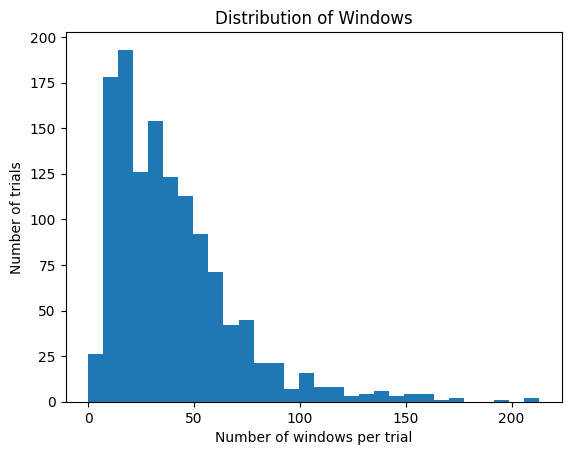

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC

def reshape_data(data, y):
    """
    Converts data from:
    recordings x windows x features x channels
    to:
    recordings x windows x (features * channels)
    """

    # Convert X_train to list if it isn't already
    X_list = list(data)  # each element = recording with shape (windows, features, channels)
    y = list(y)

    X_clean = []
    y_clean = []

    for i, rec in enumerate(X_list):
        if np.array(rec).shape[0] > 0:   # keep only recordings with >0 windows
            X_clean.append(np.mean([w for w in rec], axis=0))  # mean across windows
            y_clean.append(y[i])  # keep corresponding label

    # Convert to arrays
    X_mean = np.array(X_clean)  # shape: (recordings_kept, features, channels)
    y_filtered = np.array(y_clean)

    # Optional: flatten for SVM
    X_svm = X_mean.reshape(X_mean.shape[0], -1)
    return X_svm, y_filtered

def plot_trials_histogram(data):
    # Convert pandas Series → list
    data_list = data.to_numpy()   # data is your Series

    # Count windows per trial
    window_counts = [len(trial) for trial in data_list]

    # Plot histogram
    plt.figure()
    plt.hist(window_counts, bins=30)
    plt.xlabel("Number of windows per trial")
    plt.ylabel("Number of trials")
    plt.title("Distribution of Windows")
    plt.show()

dataset = df
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_feature'], dataset['movement'], test_size=0.2, random_state=42)
plot_trials_histogram(X_train)


To start, let's just classify pinch vs fist.

Test accuracy: 96.49%

Classification report:
              precision    recall  f1-score   support

        fist     0.9643    0.9643    0.9643        28
       pinch     0.9655    0.9655    0.9655        29

    accuracy                         0.9649        57
   macro avg     0.9649    0.9649    0.9649        57
weighted avg     0.9649    0.9649    0.9649        57



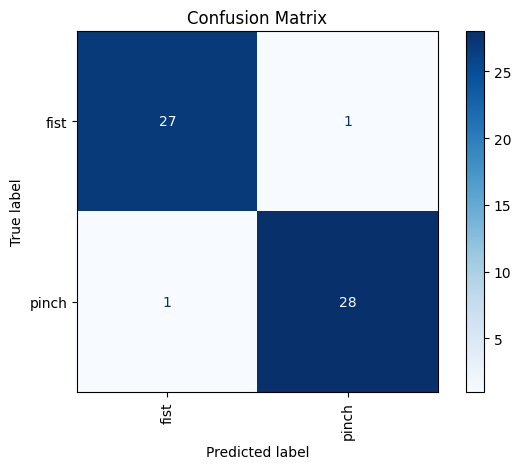

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
)

dataset = df
dataset = dataset[dataset['movement'].isin(['pinch', 'fist'])]

X_train, X_test, y_train, y_test = train_test_split(dataset['windows_feature'], dataset['movement'], test_size=0.2, random_state=42)

X_train_svm, y_train = reshape_data(X_train, y_train)
X_test_svm, y_test = reshape_data(X_test, y_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_svm)
X_train_scaled = scaler.transform(X_train_svm)
X_test_scaled = scaler.transform(X_test_svm)

clf = LinearSVC(random_state=0, max_iter=10000)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc*100:.2f}%")
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

# Nice confusion matrix plot with labels + colorbar legend
# after ConfusionMatrixDisplay.from_predictions(...)
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=clf.classes_,
    cmap="Blues",
    normalize=None,
    values_format="d",
    colorbar=True,
)

# Rotate the x-axis (bottom) tick labels vertical
ax = disp.ax_
plt.setp(ax.get_xticklabels(), rotation=90, ha="center", va="top")

plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()


Test accuracy: 83.39%

Classification report:
              precision    recall  f1-score   support

      3digit     0.6429    0.8710    0.7397        31
    cilinder     0.9706    0.9167    0.9429        36
        fist     0.8519    0.8519    0.8519        27
       index     0.7586    0.7097    0.7333        31
  index_flex     0.8750    0.9032    0.8889        31
      middle     0.8519    0.6765    0.7541        34
 middle_flex     0.7632    0.9355    0.8406        31
       pinch     0.7143    0.6522    0.6818        23
       point     0.9200    0.8519    0.8846        27
    thumbExt     1.0000    0.9615    0.9804        26
   thumbFlex     0.9474    0.8182    0.8780        22

    accuracy                         0.8339       319
   macro avg     0.8451    0.8316    0.8342       319
weighted avg     0.8440    0.8339    0.8346       319



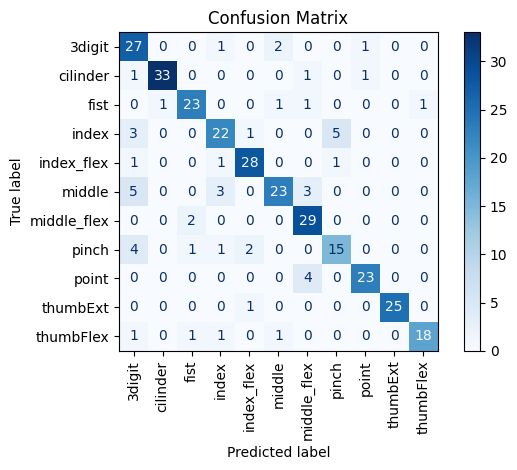

In [55]:
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt

# set up X, y test / train split
dataset = df
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_feature'], dataset['movement'], test_size=0.2, random_state=42)

# reshape
X_train_svm, y_train = reshape_data(X_train, y_train)
X_test_svm, y_test = reshape_data(X_test, y_test)

# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_svm)
X_train_scaled = scaler.transform(X_train_svm)
X_test_scaled = scaler.transform(X_test_svm)

# clf = LinearSVC(C=1.0, class_weight="balanced", max_iter=20000, random_state=0)
clf = SVC(C=10.0, kernel="rbf", gamma="scale", class_weight="balanced")
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc*100:.2f}%")
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

# Nice confusion matrix plot with labels + colorbar legend
# after ConfusionMatrixDisplay.from_predictions(...)
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=clf.classes_,
    cmap="Blues",
    normalize=None,
    values_format="d",
    colorbar=True,
)

# Rotate the x-axis (bottom) tick labels vertical
ax = disp.ax_
plt.setp(ax.get_xticklabels(), rotation=90, ha="center", va="top")

plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

Note that in the above SVM model, we take the feature average across all windows of a single recording. This is not unheard of for time series, windowed, classification model training. But taking an average across windows has shown to decrease accuracy of classifiers (https://arxiv.org/pdf/2002.00461).
Instead, let's try classifying each window independently.

In [5]:
def reshape_data_windows(data, y):
    """
    Converts data from:
    recordings x windows x features x channels
    to:
    total_windows x (features * channels)

    Labels are duplicated per window.
    """

    X_list = list(data)
    y = list(y)

    X_windows = []
    y_windows = []

    for rec_idx, rec in enumerate(X_list):
        rec = np.array(rec)

        # Skip recordings with no windows
        if rec.shape[0] == 0:
            continue

        for window in rec:
            # window shape: (features, channels)
            X_windows.append(window.reshape(-1))  # flatten to 938
            y_windows.append(y[rec_idx])           # same label per window

    X_out = np.array(X_windows)   # shape: (total_windows, 938)
    y_out = np.array(y_windows)   # shape: (total_windows,)

    return X_out, y_out

Test accuracy: 54.72%

Classification report:
              precision    recall  f1-score   support

      3digit     0.3311    0.3279    0.3295      1037
    cilinder     0.8054    0.7490    0.7762      3100
        fist     0.4817    0.6173    0.5411       810
       index     0.3333    0.2522    0.2871       928
  index_flex     0.6223    0.5507    0.5843      1104
      middle     0.4679    0.4173    0.4411      1136
 middle_flex     0.4529    0.5986    0.5156      1156
       pinch     0.3874    0.4208    0.4034       732
       point     0.5790    0.5548    0.5666       885
    thumbExt     0.5051    0.5997    0.5483       582
   thumbFlex     0.5200    0.5021    0.5109       932

    accuracy                         0.5472     12402
   macro avg     0.4987    0.5082    0.5004     12402
weighted avg     0.5528    0.5472    0.5473     12402



/Users/aidankirwin/Code/Gesture-Recognition/venv/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


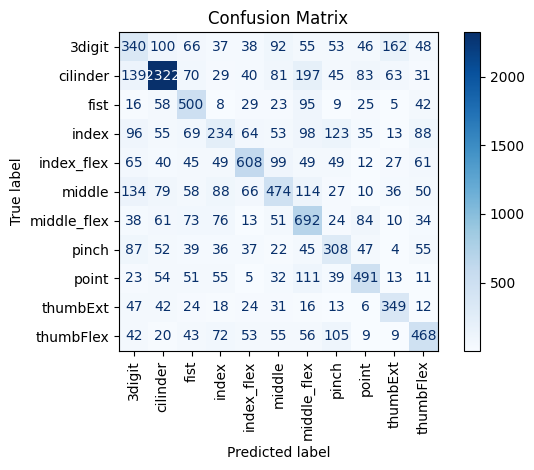

In [57]:
from sklearn.linear_model import SGDClassifier

# set up X, y test / train split
dataset = df
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_feature'], dataset['movement'], test_size=0.2, random_state=42)

# reshape
X_train_svm, y_train = reshape_data_windows(X_train, y_train)
X_test_svm, y_test = reshape_data_windows(X_test, y_test)

# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_svm)
X_test_scaled = scaler.transform(X_test_svm)

# this uses stochastic gradient descent to solve loss function and fit a linear SVM
# should be faster than LinearSVC 
clf = SGDClassifier(
    loss="hinge",        # linear SVM
    class_weight="balanced",
    max_iter=1000,
    tol=1e-3,
    random_state=0,
)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc*100:.2f}%")
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

# Nice confusion matrix plot with labels + colorbar legend
# after ConfusionMatrixDisplay.from_predictions(...)
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=clf.classes_,
    cmap="Blues",
    normalize=None,
    values_format="d",
    colorbar=True,
)

# Rotate the x-axis (bottom) tick labels vertical
ax = disp.ax_
plt.setp(ax.get_xticklabels(), rotation=90, ha="center", va="top")

plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

This did not converge and accuracy is low. Let's try again with an RBF classifier

Test accuracy: 69.65%

Classification report:
              precision    recall  f1-score   support

      3digit     0.5248    0.5911    0.5560      1037
    cilinder     0.9000    0.8387    0.8683      3100
        fist     0.6998    0.7481    0.7232       810
       index     0.4934    0.5248    0.5086       928
  index_flex     0.6686    0.7129    0.6900      1104
      middle     0.6833    0.5414    0.6041      1136
 middle_flex     0.6570    0.6860    0.6712      1156
       pinch     0.5083    0.5464    0.5267       732
       point     0.7686    0.7130    0.7397       885
    thumbExt     0.7360    0.7663    0.7508       582
   thumbFlex     0.6640    0.7082    0.6854       932

    accuracy                         0.6965     12402
   macro avg     0.6640    0.6706    0.6658     12402
weighted avg     0.7041    0.6965    0.6987     12402



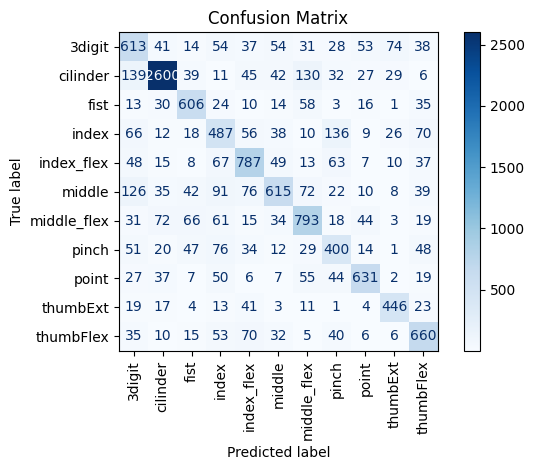

In [17]:
# set up X, y test / train split
dataset = df
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_feature'], dataset['movement'], test_size=0.2, random_state=42)

# reshape
X_train_svm, y_train = reshape_data_windows(X_train, y_train)
X_test_svm, y_test = reshape_data_windows(X_test, y_test)

# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_svm)
X_test_scaled = scaler.transform(X_test_svm)

clf = SVC(C=10.0, kernel="rbf", gamma="scale", class_weight="balanced")
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc*100:.2f}%")
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

# Nice confusion matrix plot with labels + colorbar legend
# after ConfusionMatrixDisplay.from_predictions(...)
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=clf.classes_,
    cmap="Blues",
    normalize=None,
    values_format="d",
    colorbar=True,
)

# Rotate the x-axis (bottom) tick labels vertical
ax = disp.ax_
plt.setp(ax.get_xticklabels(), rotation=90, ha="center", va="top")

plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

Let's apply cross validation and perform a hyperparameter optimization for C and gamma.
We currently have 938 features, were going to use this for both SVM (gesture classification) and linear regression (joint angle prediction).
Due to the time it takes to train a model, we're going to dimension reduce this down.

To determine how many PCs to use, we'll check explained variance.

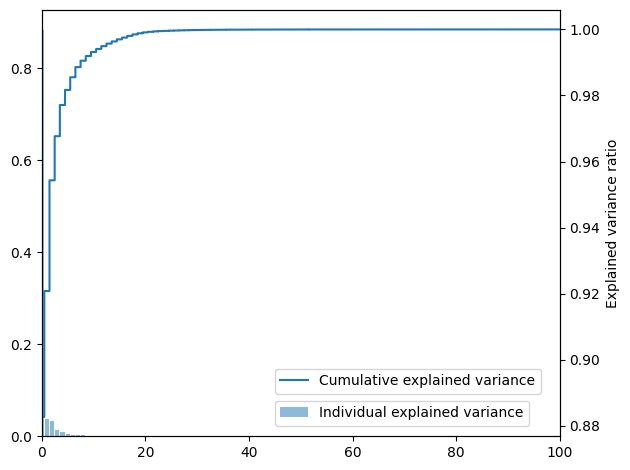

In [20]:
import sklearn.metrics
from sklearn.decomposition import PCA

dataset = pd.read_pickle('dataset.pkl')
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_feature'], dataset['movement'], test_size=0.2, random_state=42)
X_train_svm, y_train = reshape_data_windows(X_train, y_train)

pca = PCA().fit(X_train_svm)

# Data for plotting
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization
fig, ax = plt.subplots(1, 1)
ax2 = ax.twinx()
ax.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
ax.set_xlim([0, 100])
ax2.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
ax.legend(loc=(0.45, 0.025))
ax2.legend(loc=(0.45, 0.1))
plt.tight_layout()
plt.show()

We can likely achieve similar accuracy with the first 40 PCs rather than all 938 features.

(51278, 40)
Test accuracy: 53.50%

Classification report:
              precision    recall  f1-score   support

      3digit     0.3858    0.4282    0.4059      1037
    cilinder     0.8497    0.6458    0.7339      3100
        fist     0.5837    0.6457    0.6131       810
       index     0.3047    0.4203    0.3533       928
  index_flex     0.4941    0.4574    0.4751      1104
      middle     0.5124    0.4173    0.4600      1136
 middle_flex     0.5485    0.4602    0.5005      1156
       pinch     0.3348    0.4276    0.3755       732
       point     0.6617    0.5966    0.6275       885
    thumbExt     0.6157    0.6993    0.6549       582
   thumbFlex     0.3672    0.5547    0.4419       932

    accuracy                         0.5350     12402
   macro avg     0.5144    0.5230    0.5128     12402
weighted avg     0.5711    0.5350    0.5458     12402



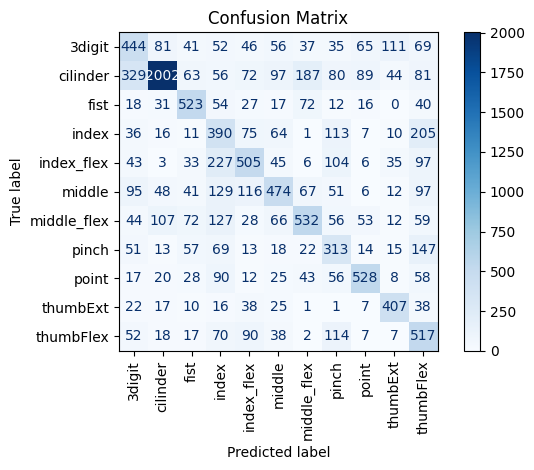

In [22]:
# set up X, y test / train split
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_feature'], dataset['movement'], test_size=0.2, random_state=42)

# reshape
X_train_svm, y_train = reshape_data_windows(X_train, y_train)
X_test_svm, y_test   = reshape_data_windows(X_test, y_test)

pca = PCA()
X_train_svm = pca.fit_transform(X_train_svm)[:, :40]
X_test_svm  = pca.transform(X_test_svm)[:, :40]

print(X_train_svm.shape)

# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_svm)
X_test_scaled = scaler.transform(X_test_svm)

clf = SVC(C=10.0, kernel="rbf", gamma="scale", class_weight="balanced")
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc*100:.2f}%")
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

# Nice confusion matrix plot with labels + colorbar legend
# after ConfusionMatrixDisplay.from_predictions(...)
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=clf.classes_,
    cmap="Blues",
    normalize=None,
    values_format="d",
    colorbar=True,
)

# Rotate the x-axis (bottom) tick labels vertical
ax = disp.ax_
plt.setp(ax.get_xticklabels(), rotation=90, ha="center", va="top")

plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

In [ ]:
### Apply cross validation to optimize C

In [ ]:
clf = SVC(C=10.0, kernel="rbf", gamma=0.1, class_weight="balanced")
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc*100:.2f}%")
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

# Nice confusion matrix plot with labels + colorbar legend
# after ConfusionMatrixDisplay.from_predictions(...)
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=clf.classes_,
    cmap="Blues",
    normalize=None,
    values_format="d",
    colorbar=True,
)

Now let's do CNN.

In [46]:
def reshape_windows_tensor_with_labels(data, y):
    """
    Converts data from:
        recordings x windows x channels x samples
    to:
        total_windows x channels x samples
    """
    X_windows = []
    y_windows = []
    data = data.to_list()
    y = y.to_list()
    for rec_idx, rec in enumerate(data):
        rec = np.asarray(rec)
        if rec.shape[0] == 0:
            continue

        for window in rec:
            X_windows.append(window)
            y_windows.append(y[rec_idx])

    return np.asarray(X_windows), np.asarray(y_windows)

In [3]:
dataset = pd.read_pickle('dataset.pkl')

(1274,)


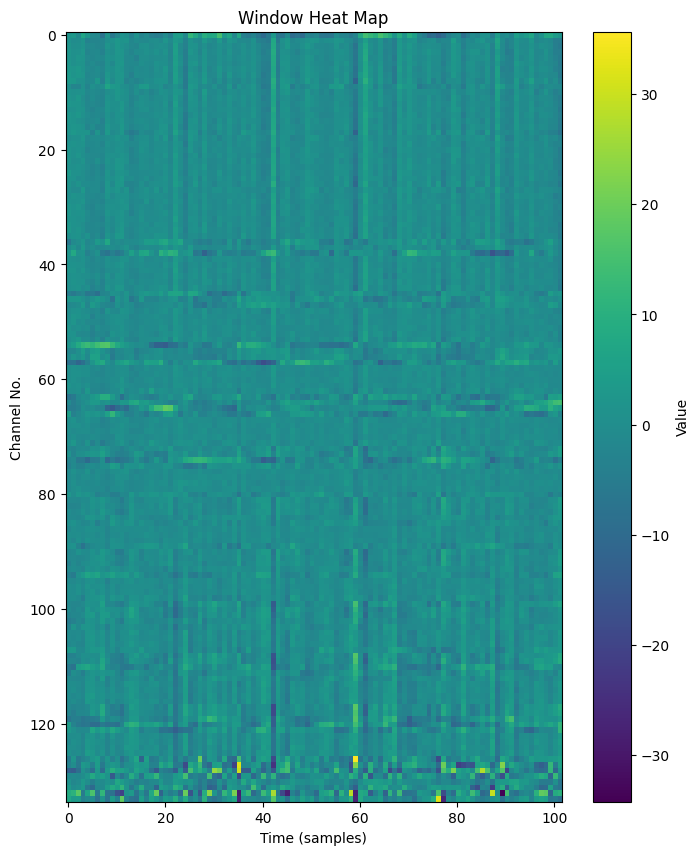

In [48]:
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_raw'], dataset['movement'], test_size=0.2, random_state=42)

print(X_train.shape)

X_train, y_train = reshape_windows_tensor_with_labels(X_train, y_train)
data = X_train[0]

plt.figure(figsize=(8, 10))
plt.imshow(data, aspect='auto', cmap='viridis')
plt.colorbar(label='Value')
plt.title(f'Window Heat Map, gesture: {y_train[0]}')
plt.xlabel('Time (samples)')
plt.ylabel('Channel No.')
plt.show()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_raw'], dataset['movement'], test_size=0.2, random_state=42)
X_train, y_train = reshape_windows_tensor_with_labels(X_train, y_train)
X_test, y_test = reshape_windows_tensor_with_labels(X_test, y_test)

Now let's do regression to build a joint angle predictor.

In [ ]:
### Joint angles regression

def reshape_windows_regression_with_angles(data, y):
    """
    Converts data from:
        recordings x windows x channels x samples
    to:
        total_windows x channels x samples
    """
    X_windows = []
    y_windows = []
    data = data.to_list()
    y = y.to_list()
    for rec_idx, rec in enumerate(data):
        rec = np.asarray(rec)
        if rec.shape[0] == 0:
            continue

        for window in rec:
            X_windows.append(window)
            y_windows.append(y[rec_idx])

    return np.asarray(X_windows), np.asarray(y_windows)

X_train, X_test, y_train, y_test = train_test_split(dataset['windows_feature'], dataset['joints'], test_size=0.2, random_state=42)